In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

%matplotlib inline
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)

def plot_data(data, x, y, x_title='x', y_title='y', xlim=None, ylim=None, size=4, alpha=0.02):
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[x],data[y])
    print '# of UTRs = ', len(data)
    print 'r-squared = ',r_value**2

    sns.set(style="ticks", color_codes=True)
    g = sns.JointGrid(data=data, x=x, y=y, xlim=xlim, ylim=ylim, size=size)
    g = g.plot_joint(plt.scatter, color='#e01145', edgecolor="black", alpha=alpha)
    f = g.fig
    f.text(x=0, y=0, s='r2 = {}'.format(round(r_value**2, 3)))
    g = g.plot_marginals(sns.distplot, kde=False, color='#e01145')
    g = g.set_axis_labels(x_title, y_title)
    
import keras
np.random.seed(1337)
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Convolution1D
from keras.constraints import maxnorm

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    #df.loc[:,'obs_stab'] = test_df['stab_df']
    predictions = model.predict(test_seq).reshape(-1)
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def binarize_sequences(df, col='utr', seq_len=54):
    vector=np.empty([len(df),seq_len,4])
    for i,seq in enumerate(df[col].str[:seq_len]):
        vector[i]=vectorizeSequence(seq.lower())
    return vector

def vectorizeSequence(seq):
    # the order of the letters is not arbitrary.
    # Flip the matrix up-down and left-right for reverse compliment
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    return np.array([ltrdict[x] for x in seq])

Using TensorFlow backend.


### Load data to get MRL values for scaling - convert the scaled predictions of the evolved sequences to MRL

In [3]:
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', ascending=False).reset_index(drop=True)

# Select a number of UTRs for the purpose of scaling.
scale_utrs = df[:40000]

# Scale
scaler = preprocessing.StandardScaler()
scaler.fit(scale_utrs['rl'].reshape(-1,1))

StandardScaler(copy=True, with_mean=True, with_std=True)

#### Choose model to use for evolving new sequences.
In the paper, the model used for evolving sequences is saved here as "evolution_model.hdf5". This is an older model that predates the main egfp model used in the paper (trained on unmodified EGFP replicate #1). The main model used in the paper is labeled "main_MRL_model.hdf5". Both retrained models are also available.

In [4]:
from keras.models import load_model
# model = load_model('../modeling/saved_models/evolution_model.hdf5')
# model = load_model('../modeling/saved_models/retrained_evolution_model.hdf5')
# model = load_model('../modeling/saved_models/main_MRL_model.hdf5')
model = load_model('../modeling/saved_models/retrained_main_MRL_model.hdf5')

### Genetic algorithm

In [5]:
import random
import math

def ret_rand_nuc():
    x = random.randint(0,3)
    if x == 0:
        return [1,0,0,0] # A
    if x == 1:
        return [0,1,0,0] # C
    if x == 2:
        return [0,0,1,0] # G
    if x == 3:
        return [0,0,0,1] # T
    
def vector_to_nuc(arr, seq_len=50):
    seq = ''
    for i in range(seq_len):
        if arr[i,0] == 1:
            seq = seq + 'A'
        if arr[i,1] == 1:
            seq = seq + 'C'
        if arr[i,2] == 1:
            seq = seq + 'G'
        if arr[i,3] == 1:
            seq = seq + 'T'
    return seq

def convert_and_save(sequences, predictions):
    # Convert the one-hot encoded sequences to A, C, T, G
    seqs = []
    for nbr in xrange(len(sequences)):
        seqs.append(vector_to_nuc(sequences[nbr]))
    df = pd.DataFrame(data=[seqs,predictions.tolist()]).transpose()
    df.columns = ['utr', 'prediction']
    df.sort_values('prediction', ascending=False, inplace=True)
    return df

def make_random_sequences(nbr_sequences, length, constant='', no_uaug=False, no_stop=False):
    # Make randomized sequences, allowing for the inclusion / exclusion of uATGs / stop codons
    seqs = []
    nucs = {0:'A', 1:'T', 2:'C', 3:'G'}
    i = 0
    while i < nbr_sequences:
        new_seq = ''
        for n in range(length - len(constant)):
            new_seq = new_seq + nucs[random.randint(0,3)]
        
        if no_uaug == False or (no_uaug==True and 'ATG' not in new_seq):
            if no_stop == False or (no_stop == True and ('TAG' not in new_seq and 'TGA' not in new_seq and 'TAA' not in new_seq)):
                new_seq = new_seq + constant
                seqs.append(new_seq)
                i+=1
    return seqs

def simple_mutate(seq, nbr_bases=1, prob=1):
    if nbr_bases > 1 and prob > random.random():
        nbr_bases = nbr_bases
    else:
        nbr_bases = 1
    for i in range(nbr_bases):
        pos = random.randint(0, 49)
        seq[pos] = ret_rand_nuc()
    return seq

def check_for_uaug(seq):
    seq = vector_to_nuc(seq)
    return 'ATG' in seq[:50]

def check_for_stops(seq):
    seq = vector_to_nuc(seq)
    if 'TAG' in seq[:50] or 'TGA' in seq[:50] or 'TAA' in seq[:50]:
        return True
    return False

def negative_selection(seq, model, scaler, target_val, no_uaug=False, no_stop=False, nbr_bases_to_mutate=1, multi_mutate_prob=1):
    seqs = np.empty([2,54,4])
    seqs[0] = seq.copy()
    seqs[1] = simple_mutate(seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=multi_mutate_prob)
    
    if no_uaug == True and check_for_uaug(seqs[1]):
        return seqs[0]
    if no_stop == True and check_for_stops(seqs[1]):
        return seqs[0]
    
    scores = model.predict(seqs).reshape(-1)
    scores = scaler.inverse_transform(scores)
    if scores[1] < scores[0]:
        if scores[1] >= target_val:
            return seqs[1]
        else:
            return seqs[0]
    else:
        return seqs[0]    

def selection(seq, model, scaler, target_val, no_uaug=False, no_stop=False, nbr_bases_to_mutate=1, multi_mutate_prob=1):
    seqs = np.empty([2,50,4])
    seqs[0] = seq.copy()
    seqs[1] = simple_mutate(seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=multi_mutate_prob)
    
    if no_uaug == True and check_for_uaug(seqs[1]):
        return seqs[0]
    if no_stop == True and check_for_stops(seqs[1]):
        return seqs[0]
    
    scores = model.predict(seqs).reshape(-1)
    scores = scaler.inverse_transform(scores)
    if scores[1] > scores[0]:
        if scores[1] <= target_val:
            return seqs[1]
        else:
            return seqs[0]
    else:
        return seqs[0]    
    
def selection_to_target(seq, model, scaler, target_val, no_uaug=False, no_stop=False, nbr_bases_to_mutate=1, multi_mutate_prob=1, seq_len=50, accept_range=0.1):
    seqs = np.empty([2,seq_len,4])
    # Save the incoming sequence before mutating
    seqs[0] = seq.copy()
    # The mutated sequence
    seqs[1] = simple_mutate(seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=multi_mutate_prob)
    
    # Decide whether to continue with the new sequence based on the uAUG / stop codon preference
    if no_uaug == True and check_for_uaug(seqs[1]):
        return seqs[0]
    if no_stop == True and check_for_stops(seqs[1]):
        return seqs[0]
    
    scores = model.predict(seqs).reshape(-1)
    scores = scaler.inverse_transform(scores)
    
    # Accept sequences that fall within this range. May provide more sequence diversity
    if scores[0] >= target_val - accept_range and scores[0] <= target_val + accept_range:
        return seqs[0]
    else:
        if abs(target_val - scores[1]) <= abs(target_val - scores[0]):
            return seqs[1]
        else:
            return seqs[0]    

_____

### Evolve new sequences to hit target MRLs

In [6]:
# Dictionary where new sequences are saved
evolved_seqs = {}

# Number of evolution iterations
iterations = 800
# Number of bases to mutate if the probability to 'multi-mutate' is exceeded
nbr_bases_to_mutate = 2
# Probability to change multiple bases in an iteration
prob_of_multi_mutation = 0.5
# If using the original evolution model, set seq_len to 54. That model was
# trained on UTRs that included the first for basees of the CDS (ATGG).
seq_len = 50
# Choose target MRLs and the number of sequences to create for each
targets = [5, 8]
seqs_per_target = [10, 10]
# Choose whether or not to allow uAUGs and / or stop codons
no_uaug = True
no_stop = False

for target_rl, nbr_sequences in zip(targets, seqs_per_target):
    print 'Working on target_rl {} with {} sequences:'.format(target_rl, nbr_sequences),
    
    # Randomly generate starting sequences for evolving
    rand_seqs = make_random_sequences(nbr_sequences, seq_len, no_uaug=no_uaug, no_stop=no_stop)
    test_sequences = np.empty([len(rand_seqs), seq_len, 4])
    i = 0
    
    # One-hot encode sequences
    for seq in rand_seqs:
        test_sequences[i] = vectorizeSequence(seq.lower())
        i += 1
    
    # Evolve sequences
    for generation in range(0, iterations):
        for i in range(len(test_sequences)):
            test_sequences[i] = selection_to_target(seq=test_sequences[i], model=model, scaler=scaler, target_val=target_rl,no_uaug=no_uaug,
                                        no_stop=no_stop, nbr_bases_to_mutate=nbr_bases_to_mutate, multi_mutate_prob=prob_of_multi_mutation, seq_len=seq_len)

        if (generation + 1) %  20 == 0:
            print generation + 1,            
    print
    # Final prediction then convert to text sequence
    predictions = model.predict(test_sequences).reshape(-1)
    predictions = scaler.inverse_transform(predictions)
    converted_df = convert_and_save(test_sequences,predictions)
    
    evolved_seqs[target_rl] = converted_df

Working on target_rl 5 with 10 sequences: 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800
Working on target_rl 8 with 10 sequences: 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


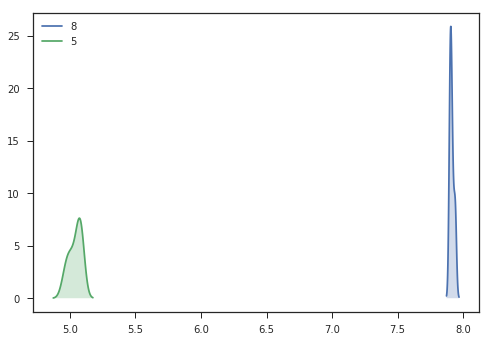

In [7]:
for i in evolved_seqs:
    sns.kdeplot(evolved_seqs[i]['prediction'], shade=True, legend=True, label=i)

In [8]:
evolved_seqs[8].head()

,utr,prediction
4,AAGTTGACGTAGAATTATACTTTCGGATCTTCATTGCACTAGACGTTGAT,7.94126
0,GAGAGAAAAAAGAGTTCAGAGTTAGTAGTGTACAGAGAGATCTGTTGGAT,7.93827
9,TTGGATCTCGTTTTATTTACTTGGAGTACAGAGTCGTATTACTAGATCCC,7.9233
1,GTGGAGTTTATCCAATCTACTTGGATTCCGAGTTCTTTGCAGGAAGAGCT,7.91531
6,ATCAATTGAGAGAGTCTTACAAATTCGATTTGGACGTCGACGCGAGGGTC,7.91183
